# Generalised Forward-Backward to solve Discrete Optimal Transport

<div class="alert alert-block alert-success">
    
This notebook we aim at solving DOT instances using modern optimisation algorithms that outperform the simplex method. To do this we will use the Generalised Forward-Backward framework. 
    
The notebook is divided in three parts. First, Condat's projection into the ℓ<sub>1</sub> ball algorithm is implemented. Second, the algorithm is used to find feasible solutions of DOT. Finally, the Generalised Forward-Backward algorithm is tested. The results are automatically stored with an unique identifier and some performance plots are presented.
</div>

* Laurent Condat. <i>Fast projection onto the simplex and the ℓ<sub>1</sub> ball</i>. Math. Program. 158, 575–585 (2016). [https://doi.org/10.1007/s10107-015-0946-6](https://doi.org/10.1007/s10107-015-0946-6). _Also available at_ [https://hal.archives-ouvertes.fr/hal-01056171v2](https://hal.archives-ouvertes.fr/hal-01056171v2).

* Hugo Raguet, Jalal Fadili, and Gabriel Peyre. <i>Generalised Forward-Backward Splitting</i>. SIAM J. Imaging Sci., 6(3), 1199–1226 (2013). [https://doi.org/10.1137/120872802](https://doi.org/10.1137/120872802). _Also available at_ [https://arxiv.org/pdf/1108.4404.pdf](https://arxiv.org/pdf/1108.4404.pdf).

<div class="alert alert-block alert-info">
Packages
</div>

In [1]:
import numpy  as np
import pandas as pd
import time
import os
import matplotlib.pyplot as plt

# Particular functions
from numpy import zeros, zeros_like, allclose, where, ones, inf, absolute, linspace
from numpy.random import default_rng as rng
from numba import jit
from scipy.spatial.distance import cdist
from scipy.linalg import norm

# Subroutines

In this section we create subroutines that will be iteratively used in the main algorithm.

## Projection onto the simplex

Here we provide an implementation of Condat's algorithm. The main steps are precompiled using the Just-in-time package ```numba``` to gain a speed-up. To get the best computing times, the resulting jitted function has to be run at least once before an actual iterative test. For the tests, we will project a random vector $y$ of size $N$ with $y_n \sim \mathcal{U}(-1,2)$ for all $n\in \{1,\ldots,N\}$ and a 20% mask of zeroes.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Condat's Algorithm</h2>
<ol>
<li>Set $v:= (y_1)$, $u$ as an empty list, $\rho:= y_1 - a$.</li>
<li>For $n \in \{2,\ldots, N\}$, do
<ol>
<li>If $y_n > \rho$
<ol>
<li>Set $\rho := \rho + (y_n - \rho)/(|v|+1)$.</li>
<li>If $\rho > y_n - a$, add $y_n$ to $v$.</li>
<li>Else, add $v$ to $u$, set $v = (y_n)$, $\rho = y_n -a$.</li>
</ol>
</li>
</ol>
</li>
<li>If $u$ is not empty, for every element $y$ of $u$, do
<ol>
<li>If $y > \rho$, add $y$ to $v$ and set $\rho := \rho + (y-\rho)/|v|$.</li>
</ol>
</li>
<li>Do, while $|v|$ changes,
<ol>
<li>For every element $y$ of $v$ do
<ol>
<li>If $y\leq \rho$, remove $y$ from $v$ and set $\rho := \rho + (\rho - y)/|v|$.</li>
</ol>
</li>
</ol>
</li>
<li>Set $\tau := \rho$, $K = |v|$.</li>
<li>For $n \in \{1,\ldots,N\}$, set $x_n := \max \{y_n - \tau, 0\}$.</li>
</ol>
</div>

In [2]:
N = 1000
y = rng(0).uniform(-1,2,N);    y = where(rng(0).binomial(1,0.8,N), y, 0)
a = 1.0

In [3]:
@jit(nopython=True, fastmath = True)
def CondatP_1d(y,a,N):
    x = zeros_like(y)
    if a == 0:
        return x
    
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [4]:
# Run things once for pre-compiling:
CondatP_1d(y,a,N);

In [5]:
# If we run the above again, we can see a clear speed-up. The computation passes quickly even inside compositions
allclose(CondatP_1d(y,a,N).sum(), 1.0)

True

Now we addapt the code to accept a matrix $\gamma$ as input.

In [6]:
N = 500
M = 1000
γ = rng(0).uniform(-1,2,(M,N));    γ = where(rng(0).binomial(1,0.8,(M,N)), γ, 0)
a = 1.0

We can pre-allocate some memory:

In [7]:
x = zeros_like(γ)

In [8]:
@jit(nopython=True, fastmath = True)
def CondatP(y,x,a,N):
    if a == 0:
        return x
    
    # Step 1
    ρ = y[0] - a
    v = [0]
    u = []
    # Step 2
    for n in range(1,N):
        yₙ = y[n]
        if yₙ > ρ:
            ρ += (yₙ - ρ)/( len(v) + 1 )
            if ρ > yₙ - a:
                v.append(n)
            else:
                u.extend(v)
                v = [n]
                ρ = yₙ - a
    # Step 3
    if len(u) > 0:
        for n in iter(u):
            yₙ = y[n]
            if yₙ > ρ:
                v.append(n)
                ρ += (yₙ - ρ)/( len(v) )
    # Step 4
    while True:
        ℓ_v = len(v)
        for i,j in enumerate(v):
            if y[j] <= ρ:
                ρ += (ρ - y[j])/(len(v) - 1)
                del v[i]
        if len(v) >= ℓ_v:
            break
    
    #x[v] = y[v] - ρ
    for n in iter(v):
        x[n] = y[n] - ρ
    #for n in prange(len(v)):
    #    x[v[n]] = y[v[n]] - ρ
    return x

In [9]:
CondatP(γ[0],x[0],a,M); # Null test

In [10]:
start = time.time()
x = zeros_like(γ)
for i in range(M):    x[i] = CondatP(γ[i],x[i],a,N)
end = time.time()
print('Time taken:',end-start,'s')

Time taken: 0.019817352294921875 s


In [11]:
allclose(x.sum(axis=1), 1)

True

An additional test can be to see what happens if we work on the support of $\gamma$:
```Python
x = zeros_like(γ)
for i in range(N):
    z = γ[i][γ[i] != 0]
    x[i][γ[i] != 0] = CondatP_1d(z,a,z.size)
```

There does not seem to be a significant gain on working with the support. This might change if the support is extremely small.

# Algorithm

Now, we will run the Generalised Forward-Backward algorithm addapted for DOT. To test it, we will run it against some of the DOTMark files. We will aim to transport from one given image to another, which are normalised and flattened in ```C```-order. The matrix of costs is based on a uniform grid within $[0,1]^2$ with $M$ points for the source and $N$ points for the target.

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Generalised Forward Backward (Full Splitting) Algorithm</h2>
We will recast our optimisation algorithm in the form
\[\min_{\gamma \in \mathbb{R}^{M \times N}} K(\gamma) + \imath_{\mathbb{R}^{M \times N}_{+}}(\gamma) + \sum^{N}_{j=1}\imath_{\mathcal{H}^{M}_{j}}(\gamma_{j}) + \sum^{M}_{i=1}\imath_{\mathcal{H}^{N}_{i}}(\gamma_{i}) ,\]
 where \[\mathcal{H}^{M}_{j} = \{x \in \mathbb{R}^{M} \mid \mathbb{1}^{T}_{M}x \geq n_{j} \},\]
    \[\mathcal{H}^{N}_{i} = \{x \in \mathbb{R}^{N}\mid \mathbb{1}^{T}_{N}x \leq m_{i} \}.\]

## Instance information

In [12]:
folder = 'Microscopy_Sized'
path = 'Exact/' + folder + '/'

In [13]:
files = [f[:-9] for f in os.listdir(path) if f.endswith('.txt')]
print('There are', len(files), 'instances in this location:')
display(files)

There are 4 instances in this location:


['data8_1002-data8_1010_p=S2',
 'data32_1002-data32_1010_p=S2',
 'data16_1002-data16_1010_p=S2',
 'data64_1002-data64_1010_p=S2']

Select one instance:

In [24]:
instance = files[1]
full_path = path + instance

Load data:

In [25]:
m = np.load(full_path + '_m.npy');    M = m.size
n = np.load(full_path + '_n.npy');    N = n.size
c = np.load(full_path + '_Cost.npy')
sol = np.load(full_path + '_Sol.npy')

In [26]:
with open(full_path + '_Time.txt', 'r') as f:
    obj_exact = eval((f.readlines())[0])['Obj']

## Run algorithm

<div class="alert alert-block alert-warning">
    
In what follows, we provide tests for the chosen instance running the Generalised forward-backward split approach given by Hugo Raguet, Jalal Fadili, and Gabriel Peyre (2013).
</div>

In [27]:
def Projection(x,b,dim):
    #projection onto the set \{x : aT x = b \}
    Px = x -(sum(x)-b)*np.ones(dim)/(dim)
    return Px

In [28]:
def generalised_forward_backward_full_split(c,m,n,iters, collect_obj = False, 
                                                 true_obj = None,
                                             true_obj_tol = 1e-4, true_solution = None, save_iter = False):
    # Algorithm for calculating solution x, in the primal space
    # and y_1, y_2 in the dual space.
    # Also returns the value of the objective function c*x at each
    # iteration.
    
    '''
        Initialise parameters
    '''
    #First compute μ
    μ = norm(c,2)     # 1 -> 10^-1 -> 10^-2 -> ...
    # μ is selected as the midpoint of the interval
    #e = 1/mu #0.5 * 1/mu;        # remove
    # γ->θ does not depend on the current iteration
    θ = 0.0001
    # likewise, we do not require a change in λ
    λ = 1.0
    
    # Fetch lengths of m and n
    N = n.size;        M = m.size
    
    print('\n*** Generalised FB with M = {}, N = {}, MN = {} ***\n\n'.format(M,N,M*N))
    
    '''
        Initialise matrices
    '''
    # Initialise y_1 and y_2
    v_1 = zeros((M,N))
    v_2 = zeros((M,N))
    v_3 = zeros((M,N))
    
    v_1[0,:] = n
    v_2[:,0] = m
    
    
    # Initialise x
    x = 0.5*(v_1 + v_2) #maybe change this
    #x = np.zeros((M,N));    x[:,0] = m;    x[0,:] = n;    x[0,0] = 0.5*(m[-1] + n[-1])        # Alternative
    
    '''
        Information from true solution (if available)
    '''
    # Store current objective value
    if collect_obj == True:
        obj = [(c*x).sum()]
    
    # Norm of true solution
    if true_solution is not None:
        true_obj_crit = 1.0
        if true_obj is None:
            true_obj = (c*sol).sum()
        print('Objective from ground truth:', obj_exact,'\n')
        
    '''
        Iterate the Generalised FB scheme
    '''
    
    every_iter = {'it':[], 'obj':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    every_critical = {'it':[], 'obj':[], 'tol':[], 'dist_obj':[], 'time':[], 'dist_x':[]}
    
    if true_solution is not None:
        print('     It  |  Tolerance |        Time       | Frob. dist. ')
        print( '{:-^55}'.format('') )
    
    start = time.time()    
    for k in range(iters):
    
        #matrices for projection over the simplex C_1^m and the simplex C_2^n.
        
        γ_1 = 2*x - v_1 - θ*c #constraint rows
        γ_2 = 2*x - v_2 - θ*c # constraint columns
        γ_3 = 2*x - v_3 - θ*c #positivity constraint
            
        # Projection to 1ᵀx = n
        Pₙ = γ_2 + (n - γ_2.sum(0))/M          # to check the constraint run: allclose(Pₙ.sum(0), n)
        # Projection to xᵀ1 = m
        #Pₘ = (γ_1.T + (m - γ_1.sum(1))/N).T    # to check run: allclose(Pₘ.sum(1), m)
        
        
        # Alternative:
        Pₘ = γ_1 + ((m - γ_1.sum(1))/N).reshape(M,1)
        
        v_1 += Pₘ - x
            
        v_2 +=  Pₙ - x
        #positivity constraint
        v_3 += np.where(γ_3<0,0,γ_3) - x
      
    
        # Update x using v_1 and v_2
        x = (v_1 + v_2 + v_3)/3
        # Measure time up to this point!
        end = time.time()
        
        # Update objective function
        if collect_obj == True:
            obj.append( (c*x).sum() )
            # Compute relative objective distance
            if true_solution is not None:
                dist_true_sol = abs(obj[-1] - true_obj)/true_obj
        
        # If all iterations are to be stored:
        if save_iter == True:
            frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
            every_iter['it'].append( k )
            every_iter['obj'].append( (c*x).sum() )
            every_iter['dist_obj'].append( dist_true_sol if true_obj is not None else np.nan )
            every_iter['time'].append( end-start )
            every_iter['dist_x'].append( frob_d )
            
           #print(dist_true_sol) 
            
        # If a true solution is available, we check the tolerance:
        if true_solution is not None: 
            if dist_true_sol < true_obj_crit:
                frob_d = norm(sol-x, 'fro')/norm(sol, 'fro')
                
                every_critical['it'].append( k )
                every_critical['obj'].append( obj[-1] )
                every_critical['tol'].append( true_obj_crit )
                every_critical['dist_obj'].append( dist_true_sol )
                every_critical['time'].append( end-start )
                every_critical['dist_x'].append( frob_d )
                
                print('* {0:6.0f} |    {1:.1e} | {2:15.2f} s |    {3:4.4f}'.format(k,true_obj_crit,end-start,frob_d))
                
                # If the prescribed tolerance is reached, we finish.
                if dist_true_sol < true_obj_tol:
                    print('Solution found with given tolerance.')
                    break
                
                # Adjust current level of inner tolerance
                true_obj_crit *= 0.1
                
    if true_solution is not None:
        print( '{:-^55}'.format('') )
        
    print('\nAlgorithm stopped after {0:.4f} seconds and {1} iterations'.format(end-start,k))
    
    
    if collect_obj == False and save_iter == True:
        return x, every_iter
    if collect_obj == True and save_iter == True:
        return x, obj, every_critical, every_iter
    else:
        return x

In [29]:
x, obj, every_critical, every_iter = generalised_forward_backward_full_split(c,m,n, 1000000, 
                                                                        collect_obj = True, 
                                                                           true_obj = obj_exact,
                                                                       true_obj_tol = 1e-7,
                                                                      true_solution = sol, 
                                                                          save_iter = True)


*** Generalised FB with M = 1024, N = 1024, MN = 1048576 ***


Objective from ground truth: 0.010675024052995653 

     It  |  Tolerance |        Time       | Frob. dist. 
-------------------------------------------------------
*    235 |    1.0e+00 |           17.80 s |    0.9165
*    368 |    1.0e-01 |           26.77 s |    0.8862
*    428 |    1.0e-02 |           30.83 s |    0.8737
*    430 |    1.0e-03 |           30.97 s |    0.8732


KeyboardInterrupt: 

## Visualise and store results

In [32]:
main_folder = folder + '_Results'
out_folder  = main_folder + '/' + instance
algorithm   = 'GFB-'

In [33]:
# Check if main folder for results exists, else create it
if not os.path.exists(main_folder):    os.makedirs(main_folder)
# Now create a folder for the results of the instance
if not os.path.exists(out_folder):    os.makedirs(out_folder)
out_folder += '/' + algorithm

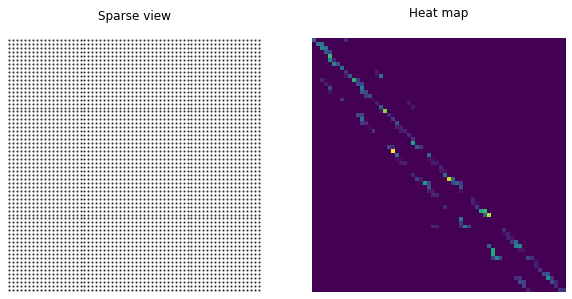

In [34]:
# Visualise solution
plt.figure(figsize = (10,5))

plt.subplot(1, 2, 1)
plt.spy(x, markersize=1, aspect = 1, markeredgecolor = 'black', alpha=0.75);    plt.axis('off')
plt.title('Sparse view')
plt.subplot(1, 2, 2)
plt.imshow(x);    plt.axis('off');    plt.title('Heat map\n')

plt.savefig(out_folder+'Sparse-Heat.pdf', bbox_inches='tight',transparent=True)
plt.show()

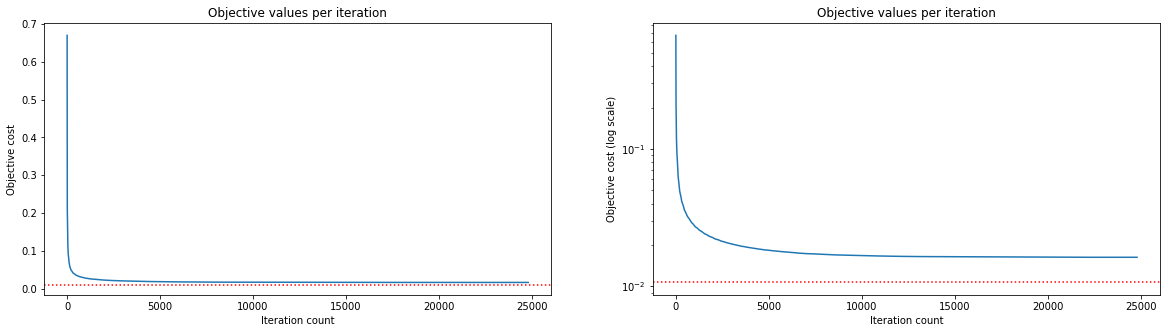

In [35]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost');    plt.title('Objective values per iteration')
plt.subplot(1, 2, 2)
plt.plot(obj)
plt.axhline(y=obj_exact, color='r', linestyle=':')
plt.yscale('log')
plt.title('Objective values per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective cost (log scale)')

plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

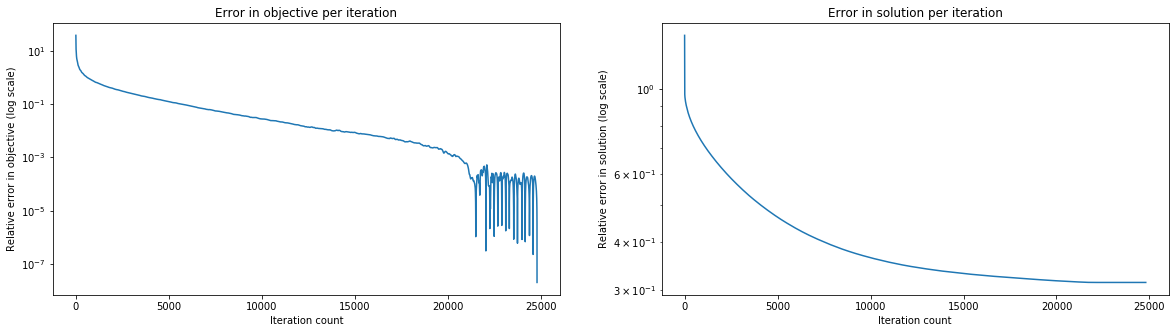

In [36]:
# Visualise evolution of relative errors
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['dist_obj'])
plt.yscale('log')
plt.title('Error in objective per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in objective (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['dist_x'])
plt.yscale('log')
plt.title('Error in solution per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Relative error in solution (log scale)')

plt.savefig(out_folder+'Rel_Error.pdf', bbox_inches='tight',transparent=True)
plt.show()

All the data from the above two plots is also available as dataframes:

In [37]:
df_critical = pd.DataFrame.from_dict(every_critical)
df_critical.to_pickle(out_folder+'Critical.pkl') # To read back use pd.read_pickle(file_name)
df_critical.to_excel(out_folder+'Critical.xlsx')
display(df_critical)

# If we want this table in LaTeX format run:
print(df_critical.to_latex(index=False))

,it,obj,tol,dist_obj,time,dist_x
0,606,0.032542,1.000000e+00,9.999017e-01,0.089521,0.774254
1,5673,0.017899,1.000000e-01,9.998305e-02,0.725965,0.442874
2,13767,0.016434,1.000000e-02,9.997121e-03,1.870492,0.336804
3,20622,0.016288,1.000000e-03,9.979150e-04,2.718120,0.316317
4,21451,0.016273,1.000000e-04,9.926314e-05,2.819082,0.314782
5,21504,0.016272,1.000000e-05,8.464164e-06,2.825866,0.314692
6,22051,0.016272,1.000000e-06,3.050128e-07,2.892524,0.314328
7,24802,0.016272,1.000000e-07,1.992308e-08,3.237361,0.314321


\begin{tabular}{rrrrrr}
\toprule
    it &       obj &           tol &      dist\_obj &      time &    dist\_x \\
\midrule
   606 &  0.032542 &  1.000000e+00 &  9.999017e-01 &  0.089521 &  0.774254 \\
  5673 &  0.017899 &  1.000000e-01 &  9.998305e-02 &  0.725965 &  0.442874 \\
 13767 &  0.016434 &  1.000000e-02 &  9.997121e-03 &  1.870492 &  0.336804 \\
 20622 &  0.016288 &  1.000000e-03 &  9.979150e-04 &  2.718120 &  0.316317 \\
 21451 &  0.016273 &  1.000000e-04 &  9.926314e-05 &  2.819082 &  0.314782 \\
 21504 &  0.016272 &  1.000000e-05 &  8.464164e-06 &  2.825866 &  0.314692 \\
 22051 &  0.016272 &  1.000000e-06 &  3.050128e-07 &  2.892524 &  0.314328 \\
 24802 &  0.016272 &  1.000000e-07 &  1.992308e-08 &  3.237361 &  0.314321 \\
\bottomrule
\end{tabular}



In [38]:
df_every = pd.DataFrame.from_dict(every_iter)
df_every.to_pickle(out_folder+'Every.pkl') # To read back use pd.read_pickle(file_name)
df_every.to_excel(out_folder+'Every.xlsx')
display(df_every.head())

,it,obj,dist_obj,time,dist_x
0,0,0.636721,38.130306,0.000548,1.373642
1,1,0.519557,30.929879,0.000872,1.244061
2,2,0.362150,21.256291,0.001104,1.135748
3,3,0.301363,17.520526,0.001335,1.077823
4,4,0.288713,16.743142,0.001546,1.033167


In [39]:
df_every.describe()

,it,obj,dist_obj,time,dist_x
count,24803.000000,24803.000000,2.480300e+04,24803.000000,24803.000000
mean,12401.000000,0.018528,1.387008e-01,1.644948,0.401126
std,7160.153699,0.009941,6.109480e-01,0.945283,0.124256
min,0.000000,0.016264,1.992308e-08,0.000548,0.314321
25%,6200.500000,0.016321,2.992043e-03,0.792046,0.320763
50%,12401.000000,0.016500,1.401342e-02,1.692312,0.344305
75%,18601.500000,0.017632,8.361182e-02,2.468453,0.428408
max,24802.000000,0.636721,3.813031e+01,3.237361,1.373642


In [40]:
# Finally, store the latest solution:
np.save(out_folder + '_Sol.npy' , x)            # To read back just run:   np.load(outfile)

---
Code used to do performance tests in each piece of code:
```Python
start = time.time()
# ...
end = time.time()
print(end-start)

%timeit -r 10 -n 200 `function(x)`
```